---


# Online Passive-Aggressive Algorithms,  (2006)

---

Algorithms from "Crammer, Dekel, Keshet, Shalev-Shwartz, Singer, Online Passive-Aggressive Algorithms" `a`

**(Make sure you are working in a venv)**

In [7]:
# Install sklearn in the current Jupyter kernel
!python -m pip install scikit-learn

In [8]:
# Install numpy in the current Jupyter kernel
!python -m pip install numpy

In [276]:
# Install matlplotlib in the current Jupyter kernel
!python -m pip install matplotlib

# ⏩ Binary Classification 

## 1️⃣ Data Creation

We will start with binary classification so we will first create a function to produce binary classification samples. We want our labels $y \in \{ +1, -1\}$, and features $x \in \mathbb{R}^d$. Also we want to be able to produce noisy data aswell (for PA-I, PA-II).

In [762]:
from sklearn.datasets import make_classification

def create_binary_classification_data(n, d, noise_factor):
    """ Create dummy data for binary classification.
    
    :param n : Number of samples (x,y)
    :param d : Dimension of each instance (number of features)
    :param noise_factor : The fraction of samples whose class is assigned randomly
        Larger values introduce noise in the labels and make the classification task harder.
    
    :return x,y  (features, labels) , where y[i] is either -1 or +1
    """
    # Create (not-noisy) testing data for binary classification.
    # Every feature is informative, 
    # and we have no redundant features (linear combination of other features)
    X, y = make_classification(
        n_samples=n, 
        n_features=d,
        n_informative=d,
        n_redundant=0, 
        n_classes=2,
        class_sep=-1,
        flip_y=noise_factor
    )
    
    # We will work with label values -1, +1 and not 0, +1 (convert)
    y[y == 0] = -1
    
    return X, y

## 2️⃣ PA, PA I, PA II

* **PA** : Very aggressive update strategy. When a we make a bad
    prediction we project onto the subspace of the models where their prediction on this label
    is correct. This has a huge drawback: A single mislabeled (noisy) sample might cause the
    weight vector to go in a very bad direction.
* **PA I** : To deal with the problem of PA we introduce a slack variable $\xi$
    in the optimization problem. We consider the case where the objective function scales linearly with
    this variable (this relationship is defined by C). C controls the influence of the slack term on the
    objective function.
* **PA II** : To deal with the problem of PA we introduce a slack variable $\xi$
    in the optimization problem. We consider the case where the objective function scales quadratically with
    this variable (this relationship is defined by C). C controls the influence of the slack term on the
    objective function.

In [763]:
import numpy as np

def pa_0(X_train, y_train, d):
    """ 
    :param X_train : Our training instances
    :param y_train : Our training labels
    :param d : dimension of instances (number of features)
    
    :returns weight model
    """
    
    # Initialize weights
    w = np.zeros(d)
    
    # Receive instances x 
    for x, y in zip(X_train, y_train):
        # Make the prediction
        y_predict = np.sign(np.dot(w, x))

        # Suffer loss
        loss = max(0, 1 - y * np.dot(w, x))
        
        # Set
        t = loss / np.dot(x, x)
        
        # Update
        w = w + t * y * x
        
    return w

def pa_1(X_train, y_train, d, C):
    """ 
    :param X_train : Our training instances
    :param y_train : Our training labels
    :param d : dimension of instances (number of features)
    :param C : aggressiveness parameter of the algorithm. Larger values of C imply a more aggressive
        update step. Common values are [0.01, .., 100] but this varies on the problem.
    
    :returns weight model
    """
    
    # Initialize weights
    w = np.zeros(d)
    
    # Receive instances x 
    for x, y in zip(X_train, y_train):
        # Make the prediction
        y_predict = np.sign(np.dot(w, x))

        # Suffer loss
        loss = max(0, 1 - y * np.dot(w, x))
        
        # Set
        t = min(C, loss / np.dot(x, x))
        
        # Update
        w = w + t * y * x
        
    return w

def pa_2(X_train, y_train, d, C):
    """ 
    :param X_train : Our training instances
    :param y_train : Our training labels
    :param d : dimension of instances (number of features)
    :param C : aggressiveness parameter of the algorithm. Larger values of C imply a more aggressive
        update step. Common values are [0.01, .., 100] but this varies on the problem.
    
    :returns weight model
    """
    
    # Initialize weights
    w = np.zeros(d)
    
    # Receive instances x 
    for x, y in zip(X_train, y_train):
        # Make the prediction
        y_predict = np.sign(np.dot(w, x))

        # Suffer loss
        loss = max(0, 1 - y * np.dot(w, x))
        
        # Set
        t = loss / (np.dot(x, x) + 0.5/C)
        
        # Update
        w = w + t * y * x
        
    return w

## 3️⃣ Model Training - Accuracy

Now it's time to create a function so we can start testing our algorithms. We will also use `PassiveAggressiveClassifier` from `sklearn` to validify our results. The common practice is to train our model with around 75% of the data and use the rest for testing, so we will do exactly that. Our error metric will be accuracy (since we have binary classification).

In [764]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import PassiveAggressiveClassifier

def predictions(X_test, w):
    """ Return predictions from our testing data in a np.array
    :param X_test : our testing samples
    :param w : weight model
    
    :returns a np.array with the predictions
    """
    return np.array([
        np.sign(np.dot(w, x)) for x in X_test
    ])

def create_data_and_train_models(n, d, C, noise_factor):
    """ Create binary classification data and return the accuracies of the algorithms.
    
    :param n : number of samples (only 75% will be used for training)
    :param d : number of features (dimension of instances)
    :param C : aggressiveness factor for PA I/II
    :param noise_factor : The fraction of samples whose class is assigned randomly
        Larger values introduce noise in the labels and make the classification task harder.
    
    :returns accuracies (PA, PA-I, PA-II, PA-I sklearn, PA-II sklearn)
    """
    # Create data
    X, y = create_binary_classification_data(n, d, noise_factor)

    # Split into random train and test subsets
    X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.25)

    # Train models
    w_0, w_1, w_2 = pa_0(X_train, y_train, d), pa_1(X_train, y_train, d, C), pa_2(X_train, y_train, d, C)
 
    # Predictions
    y_pred_0, y_pred_1, y_pred_2 = predictions(X_test, w_0), predictions(X_test, w_1), predictions(X_test, w_2)

    # PA-I sklearn implementation to compare
    clf_1 = PassiveAggressiveClassifier(C=C, loss="hinge")
    _ = clf_1.fit(X_train, y_train)
    y_pred_sklearn_1 = clf_1.predict(X_test) # # Prediction of sklearn PA
    
    # PA-II sklearn implementation to compare
    clf_2 = PassiveAggressiveClassifier(C=C, loss="squared_hinge")
    _ = clf_2.fit(X_train, y_train)
    y_pred_sklearn_2 = clf_2.predict(X_test) # # Prediction of sklearn PA
    
    return (
        accuracy_score(y_test, y_pred_0),
        accuracy_score(y_test, y_pred_1),
        accuracy_score(y_test, y_pred_2), 
        accuracy_score(y_test, y_pred_sklearn_1),
        accuracy_score(y_test, y_pred_sklearn_2)
    )

In [765]:
create_data_and_train_models(n=5_000, d=5, C=0.01, noise_factor=0.0)

(0.6488, 0.6944, 0.6776, 0.6984, 0.6408)

## 4️⃣  Testing PA, PA I, PA II

We created a simple script that plots for increasing `noise_factor` (of created samples) the accuracy of each algorithm. You can change `noise_factor_list` manually if you want, we currently perform one test with new data for each noise_factor $\in \{0, 0.02, \dots, 0.3\}$.


In [766]:
import matplotlib.pyplot as plt

def test_and_plot(n, d, C):

    # From 0 to 0.5 with step 0.02 
    noise_factor_list = np.arange(0, 0.32, 0.02)

    # Tuples with (PA_score, PA_I_score, PA_II_score, PA_I_sklearn_score, PA_II_sklearn_score)
    accuracies = [create_data_and_train_models(n, d, C, noise_factor) for noise_factor in noise_factor_list]

    plt.plot(
        noise_factor_list, [a[0] for a in accuracies], 'o-r',
        label='PA'
    )
    plt.plot(
        noise_factor_list, [a[1] for a in accuracies], 'd-b',
        label='PA-I'
    )
    plt.plot(
        noise_factor_list, [a[2] for a in accuracies], 's-g',
        label='PA-II'
    )
    plt.plot(
        noise_factor_list, [a[3] for a in accuracies], 'p-y',
        label='PA-I sklearn'
    )

    plt.plot(
        noise_factor_list, [a[4] for a in accuracies], '^-c',
        label='PA-II sklearn'
    )

    plt.legend()
    ax = plt.gca()
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 0.3])
    plt.ylabel('accuracy')
    plt.xlabel('noise factor')
    plt.title(f'PA Classifiers , n = {n}, d = {d}, C = {C}')
    plt.show()

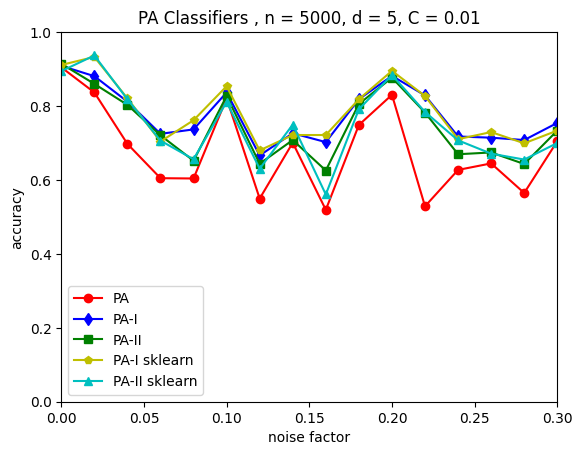

In [770]:
test_and_plot(n=5_000, d=5, C=0.01)

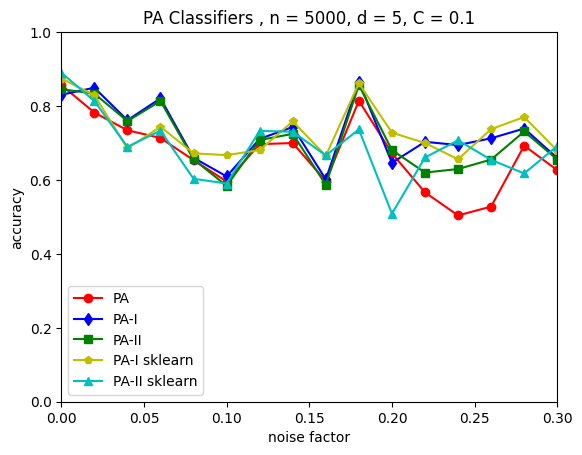

In [818]:
test_and_plot(n=5_000, d=5, C=0.1)

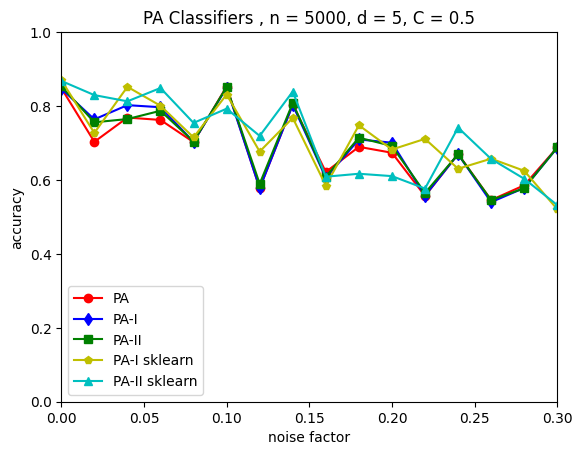

In [785]:
test_and_plot(n=5_000, d=5, C=0.5)

# ⏩ Regression

## 1️⃣  Data Creation 

We will implement a function to create regression samples. We want our labels $y \in \mathbb{R}$, and features $x \in \mathbb{R}^d$. Also we want to be able to produce noisy data aswell (for PA-I, PA-II).

In [5]:
from sklearn.datasets import make_regression

def create_regression_data(n, d, noise=0.0):
    """ Generate a random regression problem.
    
    :param n : Number of samples (x,y)
    :param d : Dimension of each instance (number of features)
    :param noise : The standard deviation of the gaussian noise applied to the output. (Default: 0.0)
    
    :return X,y  (features, labels)
    """
    # Create (not-noisy) testing data for binary classification.
    # Every feature is informative.
    X, y = make_regression(
        n_samples=n, 
        n_features=d,
        n_informative=d,
        noise=noise
    )
    return X, y

## 2️⃣ PA, PA I, PA II

* **PA** : Very aggressive update strategy. When a we make a bad
    prediction we project onto the subspace of the models where their prediction on this label
    is correct. This has a huge drawback: A single mislabeled (noisy) sample might cause the
    weight vector to go in a very bad direction.
* **PA I** : To deal with the problem of PA we introduce a slack variable $\xi$
    in the optimization problem. We consider the case where the objective function scales linearly with
    this variable (this relationship is defined by C). C controls the influence of the slack term on the
    objective function.
* **PA II** : To deal with the problem of PA we introduce a slack variable $\xi$
    in the optimization problem. We consider the case where the objective function scales quadratically with
    this variable (this relationship is defined by C). C controls the influence of the slack term on the
    objective function.

In [6]:
import numpy as np

def pa_0(X_train, y_train, d, epsilon):
    """ 
    :param X_train : Our training instances
    :param y_train : Our training labels
    :param d : dimension of instances (number of features)
    :param epsilon : The acceptable hinge loss. If |y_predict - y| <= epsilon
        we consider our prediciton to be correct, otherwise we suffer loss. (tolerance)
    
    :returns weight model
    """
    
    # Initialize weights
    w = np.zeros(d)
    
    # Receive instances x 
    for x, y in zip(X_train, y_train):
        # Make the prediction
        y_predict = np.dot(w, x)

        # Suffer loss
        loss = max(0, np.absolute(np.dot(w, x) - y) - epsilon)
        
        # Set
        t = loss / np.dot(x, x)
        
        # Update
        w = w + t * np.sign(y - y_predict) * x
        
    return w

def pa_1(X_train, y_train, d, C, epsilon):
    """ 
    :param X_train : Our training instances
    :param y_train : Our training labels
    :param d : dimension of instances (number of features)
    :param C : aggressiveness parameter of the algorithm. Larger values of C imply a more aggressive
        update step. Common values are [0.01, .., 100] but this varies on the problem.
    :param epsilon : The acceptable hinge loss. If |y_predict - y| <= epsilon
        we consider our prediciton to be correct, otherwise we suffer loss. (tolerance)
    
    :returns weight model
    """
    
    # Initialize weights
    w = np.zeros(d)
    
    # Receive instances x 
    for x, y in zip(X_train, y_train):
        # Make the prediction
        y_predict = np.dot(w, x)

        # Suffer loss
        loss = max(0, np.absolute(np.dot(w, x) - y) - epsilon)
        
        # Set
        t = min(C, loss / np.dot(x, x))
        
        # Update
        w = w + t * np.sign(y - y_predict) * x
        
    return w

def pa_2(X_train, y_train, d, C, epsilon):
    """ 
    :param X_train : Our training instances
    :param y_train : Our training labels
    :param d : dimension of instances (number of features)
    :param C : aggressiveness parameter of the algorithm. Larger values of C imply a more aggressive
        update step. Common values are [0.01, .., 100] but this varies on the problem.
    :param epsilon : The acceptable hinge loss. If |y_predict - y| <= epsilon
        we consider our prediciton to be correct, otherwise we suffer loss. (tolerance)
    
    :returns weight model
    """
    
    # Initialize weights
    w = np.zeros(d)
    
    # Receive instances x 
    for x, y in zip(X_train, y_train):
       # Make the prediction
        y_predict = np.dot(w, x)

        # Suffer loss
        loss = max(0, np.absolute(np.dot(w, x) - y) - epsilon)
        
        # Set
        t = loss / (np.dot(x, x) + 0.5/C)
        
        # Update
        w = w + t * np.sign(y - y_predict) * x
        
    return w

## 3️⃣  Model Training - Accuracy

Now it's time to create a function so we can start testing our algorithms. We will also use `PassiveAggressiveClassifier` from `sklearn` to validify our results. The common practice is to train our model with around 75% of the data and use the rest for testing, so we will do exactly that. Our error metric will be Mean Squared Error.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import PassiveAggressiveRegressor

def predictions(X_test, w):
    """ Return predictions from our testing data in a np.array
    :param X_test : our testing samples
    :param w : weight model
    
    :returns a np.array with the predictions
    """
    return np.array([
        np.dot(w, x) for x in X_test
    ])

def create_data_and_train_models(n, d, C, epsilon, noise=0.0):
    """ Create binary classification data and return the accuracies of the algorithms.
    
    :param n : number of samples (only 75% will be used for training)
    :param d : number of features (dimension of instances)
    :param C : aggressiveness factor for PA I/II
    :param noise_factor : The fraction of samples whose class is assigned randomly
        Larger values introduce noise in the labels and make the classification task harder.
    
    :returns tuple (MSE of PA, MSE of PA I, MSE of PA II, MSE of PA sklearn)
    """
    # Create data
    X, y = create_regression_data(n, d, noise)

    # Split into random train and test subsets
    X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.25)

    # Train models
    w_0, w_1, w_2 = (
        pa_0(X_train, y_train, d, epsilon),
        pa_1(X_train, y_train, d, C, epsilon),
        pa_2(X_train, y_train, d, C, epsilon)
    )
 
    # Predictions
    y_pred_0, y_pred_1, y_pred_2 = predictions(X_test, w_0), predictions(X_test, w_1), predictions(X_test, w_2)
    
    # PA-I regressor from sklearn
    regr_1 = PassiveAggressiveRegressor(C=C, epsilon=epsilon, loss="epsilon_insensitive")
    _ = regr_1.fit(X_train, y_train)
    y_pred_sklearn_1 = regr_1.predict(X_test) # predictions
    
    # PA-II regressor from sklearn
    regr_2 = PassiveAggressiveRegressor(C=C, epsilon=epsilon, loss="squared_epsilon_insensitive")
    _ = regr_2.fit(X_train, y_train)
    y_pred_sklearn_2 = regr_2.predict(X_test)
    
    
    return (
        mean_squared_error(y_test, y_pred_0),
        mean_squared_error(y_test, y_pred_1),
        mean_squared_error(y_test, y_pred_2),
        mean_squared_error(y_test, y_pred_sklearn_1),
        mean_squared_error(y_test, y_pred_sklearn_2)
    )

In [666]:
create_data_and_train_models(n=5_000, d=5, C=0.1, epsilon=0.1, noise=1)

(4.7158707812272835,
 1.604905795836561,
 1.3322484439851587,
 1.148093699017039,
 1.280334610785564)

## 4️⃣ Testing PA, PA I, PA II

We created a simple script that plots for increasing `noise` ($\sigma_g$ of added gaussian noise to the labels) the accuracy of each algorithm.

In [8]:
import matplotlib.pyplot as plt

def test_and_plot(n, d, C, epsilon):

    # The standard deviation of the gaussian noise applied to the output (labels)
    noise_list = np.arange(0, 1.55, 0.05)

    # Tuples with (PA_mse, PA_I_mse, PA_II_mse, PA_I_sklearn_mse, PA_I_sklearn_mse)
    mse_list = [create_data_and_train_models(n, d, C, epsilon, noise) for noise in noise_list]
    
    plt.plot(
        noise_list, [mse[0] for mse in mse_list], 'o-r',
        label='PA'
    )
    plt.plot(
        noise_list, [mse[1] for mse in mse_list], 'd-b',
        label='PA-I'
    )
    plt.plot(
        noise_list, [mse[2] for mse in mse_list], 's-g',
        label='PA-II'
    )
    plt.plot(
        noise_list, [mse[3] for mse in mse_list], 'p-y',
        label='PA-I sklearn'
    )

    plt.plot(
        noise_list, [mse[4] for mse in mse_list], '^-c',
        label='PA-II sklearn'
    )

    plt.legend()
    ax = plt.gca()
    #ax.set_ylim([0, 1])
    ax.set_xlim([0, 1.5])
    plt.ylabel('MSE')
    plt.xlabel('noise factor - std of added gaussian noise ($\sigma_g$)')
    plt.title(f'PA Regressors , n = {n}, d = {d}, C = {C}, $\epsilon$={epsilon}')
    plt.show()

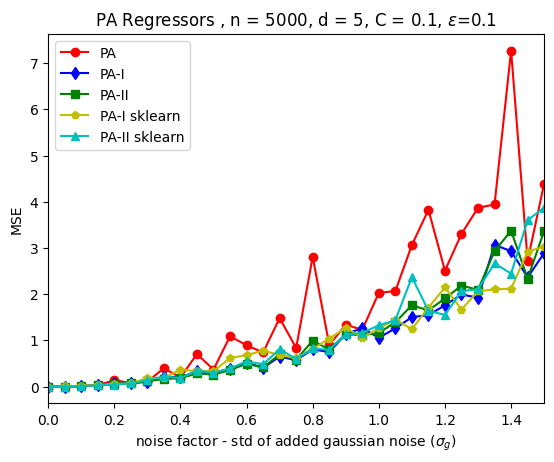

In [758]:
test_and_plot(n=5_000, d=5, C=0.1, epsilon=0.1)

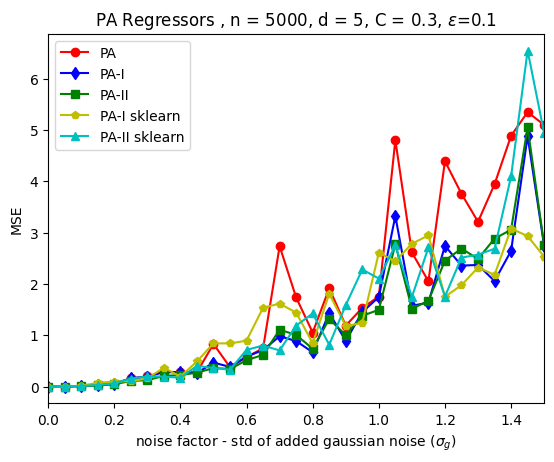

In [761]:
test_and_plot(n=5_000, d=5, C=0.3, epsilon=0.1)

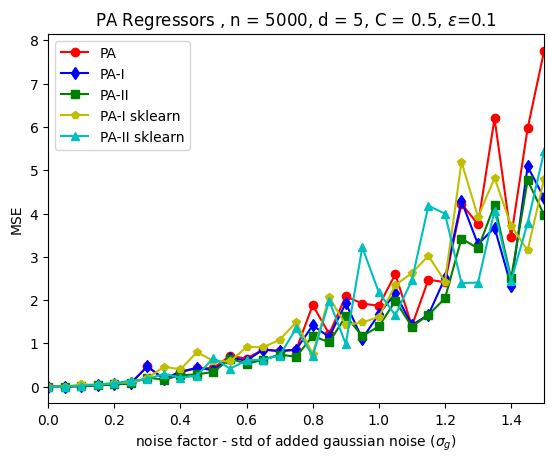

In [11]:
test_and_plot(n=5_000, d=5, C=0.5, epsilon=0.1)